## Titanic: Machine Learning from Disaster

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

This notebook presents a profound exploratory analysis of the dataset in order to provide understanding of the dependencies and interesting facts. We will then use these dependencies to create several models that will be able to predict whether a person survived the shipwreck or not. We will analyse these models and find out the best among them.

## Contents of the notebook

* ### <a href = "#eda">EDA</a>
    - Feature Analysis 
    - Finding trends in the data
    
* ### <a href = "#dcfe">Data Cleaning and Feature Engineering</a>
    - Interpolating Empty/ Nan Values 
    - Creating new features
    - Removing redundant/ unusable features
 
* ### <a href = "#ft">Feature Transformation</a>
    - Removing skeweness
    - Binning Features
    - Hot encoding features, etc    
    
* ### <a href = "#pm">Predictive Modelling</a>
    - Finding the best Algorithm
    - Tuning the best Algorithm
    - Submitting results

## EDA (Exploratory Data Analysis) <a name = "eda">

In [365]:
# Importing important libraries for EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

from IPython.display import display
%matplotlib inline

# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

rand = 7

In [366]:
# Import the datasets and have a peek at the data

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
passenger_ids = test_df["PassengerId"]

display(train_df.sample(n = 3))
display(test_df.sample(n = 3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
363,364,0,3,"Asim, Mr. Adola",male,35.0,0,0,SOTON/O.Q. 3101310,7.0500,NaN,S
267,268,1,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.7750,NaN,S
192,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,1223,1,"Dulles, Mr. William Crothers",male,39.0,0,0,PC 17580,29.700,A18,C
409,1301,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.775,NaN,S
13,905,2,"Howard, Mr. Benjamin",male,63.0,1,0,24065,26.000,NaN,S


In [367]:
# Are there any missing values?, any variables that need to be converted to another type?

print("Training Data Info\n")
display(train_df.info())

print("Testing Data Info\n")
display(test_df.info())

Training Data Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


None

Testing Data Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

<u>We get the following observations after looking at the data :</u>

#### Continious Features

1. Age
2. Fare

We need to check for any skeweness in these continious feature distributions and scale/ bin them so that they may work well with models that use distances.

#### Categorical Feature/ Nominal Features

1. Sex
2. Embarked

We would need to hot encode them.

#### Ordinal/ Interval Features
 
1. Pclass
2. SibSp
3. Parch

#### Alphanumeric

1. Name
2. Cabin

#### The following columns have null values and need to be dropped or interpolated :

1. Age (Both in training and testing data)
2. Cabin (Both)
3. Embarked (Training data)
4. Fare (Testing data)

#### The following are features we need to transform to get any information out of or need to drop them.

1. Name
2. Cabin
3. Ticket

##### Lets look at the bigger picture first. How many people actually survived the accident?

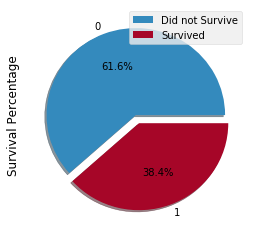

In [368]:
train_df['Survived'].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (4, 4), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Survival Percentage")
plt.legend(["Did not Survive", "Survived"])
plt.show()

It is evident from the above pie chart that a lot of people didn't survive the accident. 
The survival rate is 38.4% which is pretty low.
A not so good model can be a model that predicts everyone to not survive the accident. 
Lets deep dive into the data and see which kind of people did/didn't survive the accident

##### Also we have an Imbalanced dependent variable for our problem since there are unequal occureneces of the dependent variable survived. This could potentially lead to a flawed model. We will use stratified train_test_split and stratified cross validation split to overcome this problem. 

##### Pclass is the socio economic status of the people who onboarded the titanic. Did it affect the survival rate by any chance?

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

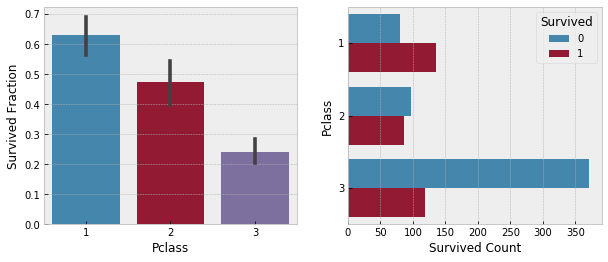

In [369]:
survival_by_class = train_df.groupby("Pclass")["Survived"].mean()
display(survival_by_class)

f, ax = plt.subplots(1, 2, figsize = (10, 4))


sns.barplot(x = "Pclass", y = "Survived", data = train_df, ax = ax[0])
ax[0].set_ylabel("Survived Fraction")

sns.countplot(y = 'Pclass', hue='Survived', data = train_df, ax = ax[1])
ax[1].set_xlabel("Survived Count")
ax[1].set_ylabel("Pclass")

plt.show()

Looks like better the socio economic status, more are the chances of survival.
Is the socio economic status by any way related to the Fare these passengers paid?

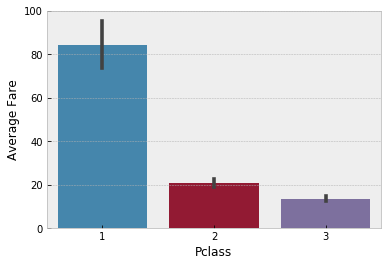

In [370]:
sns.barplot(x = "Pclass", y = "Fare", data = train_df)
plt.ylabel("Average Fare")
plt.show()

Looks like better the Socio Economic Class( Since they paid a higher fare ), more the chances of survival.

##### Did gender had any impact on the survival of the passengers ?

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

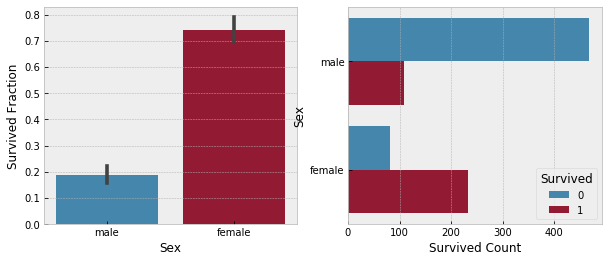

In [371]:
survival_by_sex = train_df.groupby("Sex")["Survived"].mean()
display(survival_by_sex)

f, ax = plt.subplots(1, 2, figsize = (10, 4))

sns.barplot(x = "Sex", y = "Survived", data = train_df, ax = ax[0])
ax[0].set_ylabel("Survived Fraction")

sns.countplot(y = "Sex", hue = "Survived", data = train_df, ax = ax[1])
ax[1].set_xlabel("Survived Count")

plt.show()

Looking at the above statistics, women had a higher chance of surviving then men.

##### Does the Port of Embarkation have any relation to Survival rate?

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

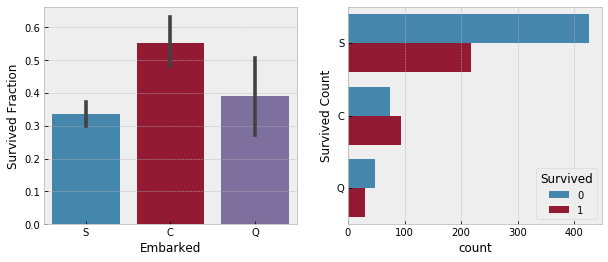

In [372]:
survival_by_port = train_df.groupby("Embarked")["Survived"].mean()
display(survival_by_port)

f, ax = plt.subplots(1, 2, figsize = (10, 4))

sns.barplot(x = "Embarked", y = "Survived", data = train_df, ax = ax[0])
ax[0].set_ylabel("Survived Fraction")

sns.countplot(y = "Embarked", hue = "Survived", data = train_df, ax = ax[1])
ax[1].set_ylabel("Survived Count")

plt.show()

Looks like there is correlation here. People who embarked from Cherbourg had a higher chance of survival than the other ports. This dosen't make sense on its own. Maybe there is another factor at play here. 
Lets study the survival rates taking into account multiple features

##### Lets check for Survival rate with Pclass and Sex together

In [373]:
pd.crosstab([train_df["Sex"], train_df["Survived"]], train_df["Pclass"], margins = True).style.background_gradient(cmap = 'summer_r')

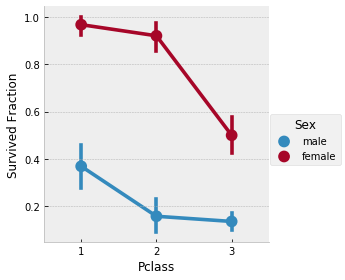

In [374]:
sns.factorplot(x = "Pclass", y = "Survived", hue = "Sex", data = train_df)
plt.ylabel("Survived Fraction")
plt.show()

The survival rate for women is better than men irrespective of class. Though the survival rate in general decreases as with decrease in socio economic status. Therefore both of these features are necessary for our analysis.

##### We earlier figured out that Cherbourg had the highest survival rate. Did majority of people from class 1 embarked from Cherbourg ?

In [375]:
pd.crosstab([train_df["Pclass"], train_df["Survived"]],train_df["Embarked"], margins = True).style.background_gradient(cmap = 'summer_r')

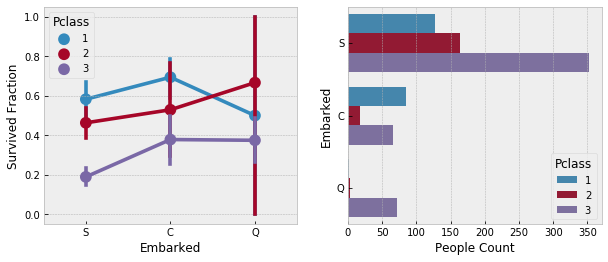

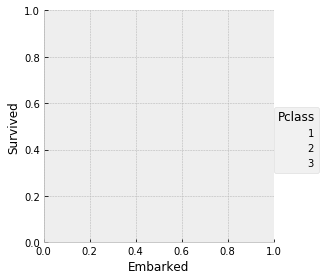

In [376]:
f, ax = plt.subplots(1, 2, figsize = (10, 4))

sns.factorplot(x = "Embarked", y = "Survived", hue = "Pclass", data = train_df, ax = ax[0])
ax[0].set_ylabel("Survived Fraction")

sns.countplot(y = "Embarked", hue = "Pclass", data = train_df, ax = ax[1])
ax[1].set_xlabel("People Count")

plt.show()

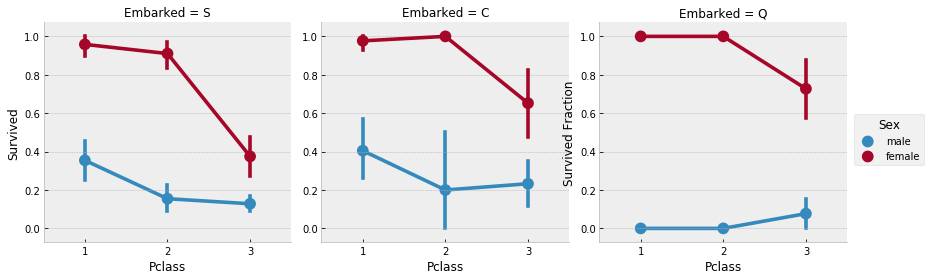

In [377]:
sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', col = 'Embarked', data = train_df)
plt.ylabel("Survived Fraction")

plt.show()

##### From Graph 2 (Count Plot):

Majority of class 1 people actually boarded from Southampton but the proportion of class 1 people is highest in Cherbourg and is almost 50%. Maybe thats why majority of people who boarded from Cherbourg had a decent rate of survival.

##### From Graph 1 (Factor Plot):

People of the same class have almost the same rate of survival among the different ports(There are some exceptions :- Class 3 people for Southampton had a lower rate of survial than the same class people who boarded from other ports and Class 2 people from Q had a higher rate of survival, even higher than class 1 people(Gender may be at play here as we can see from the last graph))

##### From Graph 3 (Multi-column-factor-plot):

Port of embarkation may not then be a good feature to determine the survival rate since once you break it down to the level of Pclass and Gender, the survival rate is almost the same irrespective of Embarkation.

##### Did Parch (Number of parents onboard)/ SibSp (Number of siblings/ spouses onboard) had any affect on Survival?

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64


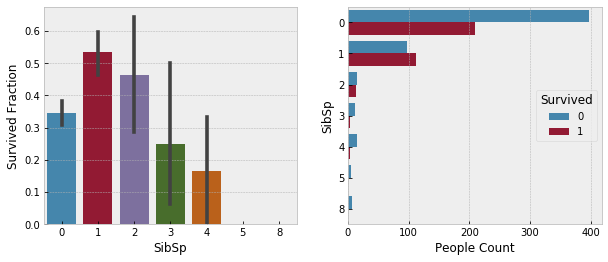

In [378]:
print(train_df.groupby("SibSp")["Survived"].mean())

f, ax = plt.subplots(1, 2, figsize = (10, 4))

sns.barplot(x = "SibSp", y = "Survived", data = train_df, ax = ax[0])
ax[0].set_ylabel("Survived Fraction")

sns.countplot(y = "SibSp", hue = "Survived", data = train_df, ax = ax[1])
ax[1].set_xlabel("People Count")

plt.show()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64


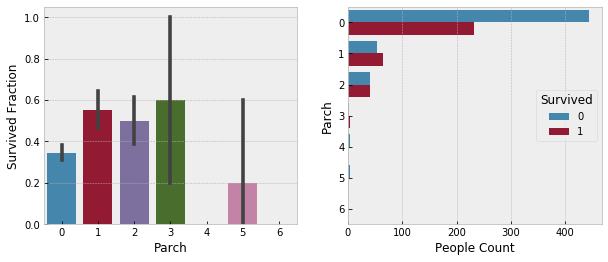

In [379]:
print(train_df.groupby("Parch")["Survived"].mean())

f, ax = plt.subplots(1, 2, figsize = (10, 4))

sns.barplot(x = "Parch", y = "Survived", data = train_df, ax = ax[0])
ax[0].set_ylabel("Survived Fraction")

sns.countplot(y = "Parch", hue = "Survived", data = train_df, ax = ax[1])
ax[1].set_xlabel("People Count")

plt.show()

More Sibling or spouses, less the chances of survival. But people who had no sibling/ spouses had an even lesser chance of survival.
Were most of these people were males? Did these people help others before helping themselves ?
Same is the case with parch.
In a nutshell, Bigger families had less survival rate, but there survival rate is better then people who travelled alone.

## Data Cleaning and Feature Engineering  <a name = "dcfe"><a>

Lets do a little bit of feature engg and study the affects of these features on the survival rate

This step is heavily taken from 'Sina'(https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier)
and 'Ash' (https://www.kaggle.com/ash316/eda-to-prediction-dietanic)

In [380]:
import math

# Has a cabin ?

def hasCabin(x):
    return int((x["Cabin"] is not np.nan))

train_df["HasCabin"] = train_df.apply(hasCabin, axis = 1)
test_df["HasCabin"] = test_df.apply(hasCabin, axis = 1)

# Combine SibSp & Parch to create a new variable FamilySize

train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1

# Use family size to create a new feature isAlone.

def isAlone(x):
    familySize = x["FamilySize"]
    return int(familySize == 1)

train_df["IsAlone"] = train_df.apply(isAlone, axis = 1)
test_df["IsAlone"] = test_df.apply(isAlone, axis = 1)

display(train_df.sample(n = 3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,FamilySize,IsAlone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S,1,2,0
816,817,0,3,"Heininen, Miss. Wendla Maria",female,23.0,0,0,STON/O2. 3101290,7.925,NaN,S,0,1,1
412,413,1,1,"Minahan, Miss. Daisy E",female,33.0,1,0,19928,90.000,C78,Q,1,2,0


##### Lets study the effects of these newly created features on survival rate

##### Lets first start with cabin.

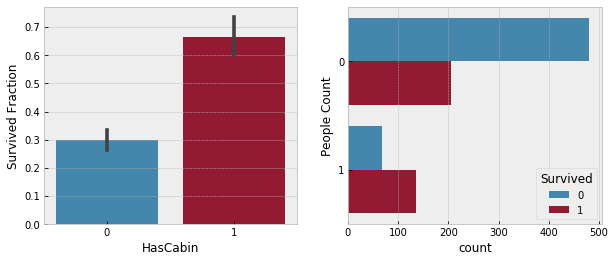

In [381]:
f, ax = plt.subplots(1, 2, figsize = (10, 4))

sns.barplot(x = "HasCabin", y = "Survived", data = train_df, ax = ax[0])
ax[0].set_ylabel("Survived Fraction")

sns.countplot(y = "HasCabin", hue = "Survived", data = train_df, ax = ax[1])
ax[1].set_ylabel("People Count")

plt.show()

People who had cabins are more likely to survive. Are most of these people from better socio economic background?

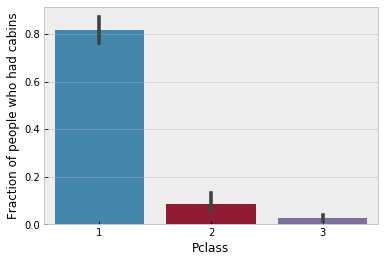

In [382]:
sns.barplot(x = "Pclass", y = "HasCabin", data = train_df)
plt.ylabel("Fraction of people who had cabins")
plt.show()

Looks like it! Maximum people who had cabins belong to class 1 which already has a higher rate of survival. Maybe these two features are correlated?

##### Did being alone have any impact on the survival rate of the passengers?

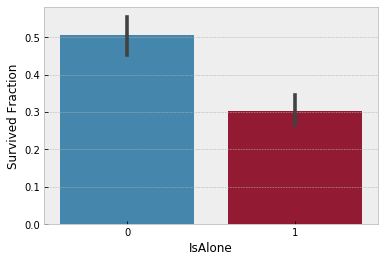

In [383]:
sns.barplot(x = "IsAlone", y = "Survived", data = train_df)
plt.ylabel("Survived Fraction")
plt.show()

People who are alone are less likely to survive. This may go on to be a useful feature.

##### Extract info about titles from Name. This may in itself turn out to be an important feature.
##### Also, we have many missing values for age. This feature will also help in us interpolating age.

In [384]:
import re

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""    
    
train_df["Title"] = train_df["Name"].apply(get_title)
test_df["Title"] = test_df["Name"].apply(get_title)

train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_df['Title'] = test_df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')

test_df['Title'] = test_df['Title'].replace('Mlle', 'Miss')
test_df['Title'] = test_df['Title'].replace('Ms', 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')

##### Now that we have extracted titles out of names. Lets study the affect of these titles on the survival rate.

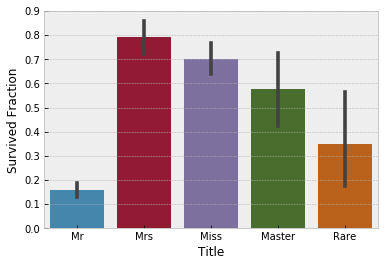

In [385]:
sns.barplot(x = "Title", y = "Survived", data = train_df)
plt.ylabel("Survived Fraction")
plt.show()

So, men had it rough ha?

##### Lets now fill in the missing age values using this new title feature and study the affect age had on survival rate

In [386]:
train_df["Age"] = train_df.groupby("Title")["Age"].transform(lambda x: x.fillna(x.mean()))
test_df["Age"] = test_df.groupby("Title")["Age"].transform(lambda x: x.fillna(x.mean()))

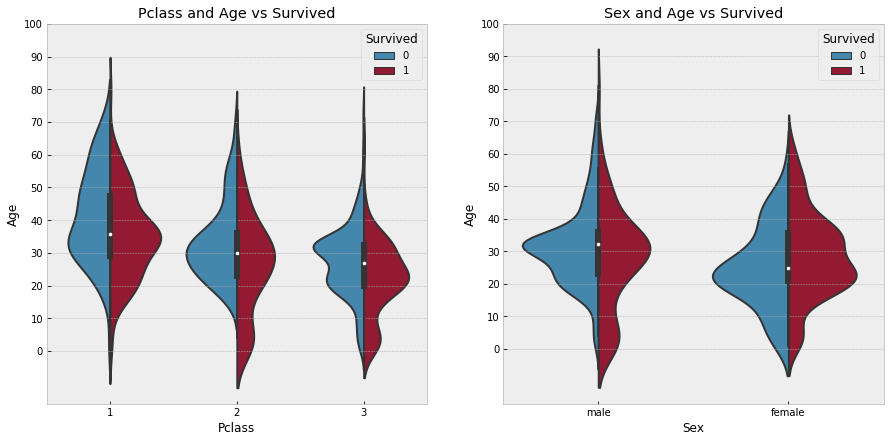

In [387]:
f,ax=plt.subplots(1,2,figsize=(15, 7))

sns.violinplot("Pclass", "Age", hue = "Survived", data = train_df, split = True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))

sns.violinplot("Sex", "Age", hue="Survived", data = train_df, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

## Feature Transformation  <a name = "ft"><a>

##### Lets start by binning age. We could have also Scaled the age to be b/w 0 - 1.

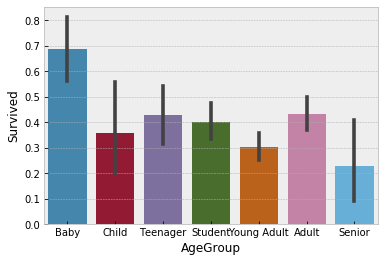

In [388]:
bins = [0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']

train_df['AgeGroup'] = pd.cut(train_df["Age"], bins, labels = labels)
test_df['AgeGroup'] = pd.cut(test_df["Age"], bins, labels = labels)

sns.barplot(x = "AgeGroup", y = "Survived", data = train_df)

Babies are more likely to survive than any other group.

In [389]:
train_df[train_df["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,FamilySize,IsAlone,Title,AgeGroup
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,1,1,Miss,Adult
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,1,1,Mrs,Senior


In [390]:
# Since the ticket is first class and the persons survived, lets fill it with C
train_df["Embarked"] = train_df["Embarked"].fillna("C")

In [391]:
test_df["Fare"] = test_df.groupby("Pclass")["Fare"].transform(lambda x: x.fillna(x.mean()))

##### Lets bin Fare. We again could have used a scaler instead of binning.

In [392]:
train_df['FareRange'] = pd.qcut(train_df['Fare'], 4)

train_df['Farecat'] = 0
train_df.loc[train_df['Fare'] <= 7.91,'Farecat'] = 0
train_df.loc[(train_df['Fare'] > 7.91) & (train_df['Fare']<=14.454),'Farecat'] = 1
train_df.loc[(train_df['Fare'] > 14.454) & (train_df['Fare']<=31),'Farecat'] = 2
train_df.loc[(train_df['Fare'] > 31) & (train_df['Fare']<=513),'Farecat'] = 3


test_df['FareRange'] = pd.qcut(test_df['Fare'], 4)

test_df['Farecat'] = 0
test_df.loc[test_df['Fare'] <= 7.91,'Farecat'] = 0
test_df.loc[(test_df['Fare'] > 7.91) & (test_df['Fare']<=14.454),'Farecat'] = 1
test_df.loc[(test_df['Fare'] > 14.454) & (test_df['Fare']<=31),'Farecat'] = 2
test_df.loc[(test_df['Fare'] > 31) & (test_df['Fare']<=513),'Farecat'] = 3

In [393]:
train_df = train_df.drop(labels=["PassengerId", "Name", "Ticket", "Cabin", "Fare", "FareRange", "Age"], axis=1)
test_df = test_df.drop(labels=["PassengerId", "Name", "Ticket", "Cabin", "Fare", "FareRange", "Age"], axis=1)

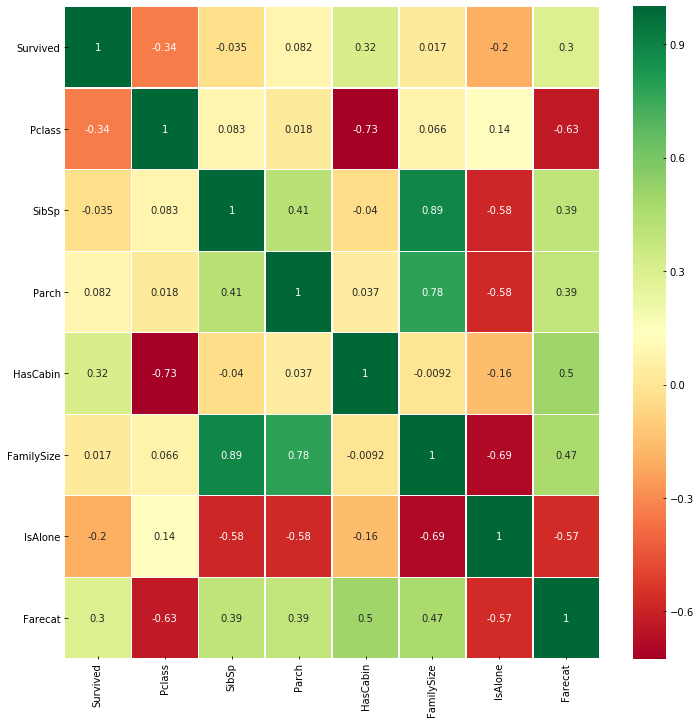

In [394]:
# Lets also solidify our findings using the correlation matrix
corr = train_df.corr()
sns.heatmap(corr, annot = True, cmap = 'RdYlGn', linewidths = 0.2)
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.show()

##### Hot encode the categorical features so that they work well with certain algorithms

In [395]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

In [396]:
display(train_df.sample(n = 5))

,Survived,Pclass,SibSp,Parch,HasCabin,FamilySize,IsAlone,Farecat,Sex_female,Sex_male,...,Title_Mr,Title_Mrs,Title_Rare,AgeGroup_Baby,AgeGroup_Child,AgeGroup_Teenager,AgeGroup_Student,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior
456,0,1,0,0,1,1,1,2,0,1,...,1,0,0,0,0,0,0,0,0,1
56,1,2,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
577,1,1,1,0,1,2,0,3,1,0,...,0,1,0,0,0,0,0,0,1,0
200,0,3,0,0,0,1,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,0,3,0,0,0,1,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0


## Model Application <a name = "pm"><a/>

In [397]:
# Split into features and target variable
features = train_df.iloc[:, 1:]
target = train_df.iloc[:, 0]

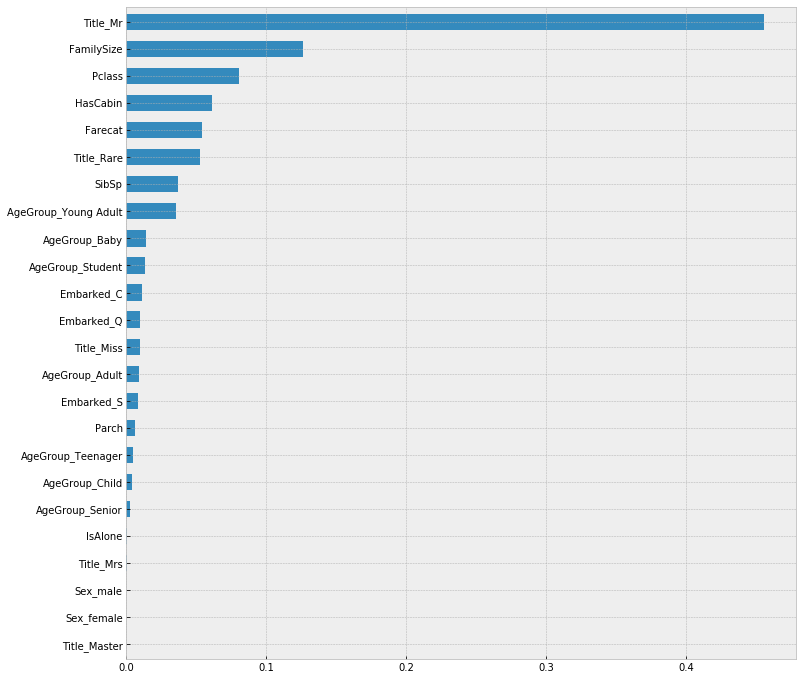

In [406]:
# Create a simple decision tree to see important features

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(min_samples_split = 10)
classifier.fit(features, target)

pd.Series(classifier.feature_importances_, features.columns).sort_values(ascending = True).plot.barh(width = 0.6)
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.show()

Looks like Title has the greatest feature importance. I am not suprised the Sex is not given any importance since title in itself would be highly correlated to sex. 

##### Helper Functions

In [400]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, stratify = target, random_state = rand)

In [401]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

In [402]:
modelResults = pd.DataFrame(columns = ['Model_Name', 'Model', 'Params', 'Test_Score', 'CV_Mean', 'CV_STD'])

def save(grid, modelName):
    global modelResults
    cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    test_score = grid.score(X_test, y_test)
    
    print("Best model parameter are\n", grid.best_estimator_)
    print("Saving model {}\n".format(modelName))
    print("Mean Cross validation score is {} with a Standard deviation of {}\n".format(cv_mean, cv_std))
    print("Test Score for the model is {}\n".format(test_score))
    
    modelResults = modelResults.append({'Model_Name' : modelName, 'Model' : grid.best_estimator_, 'Params' : grid.best_params_, 'Test_Score' : test_score, 'CV_Mean' : cv_mean, 'CV_STD' : cv_std}
                                       , ignore_index=True)

In [403]:
def doGridSearch(classifier, params):
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = rand)
    score_fn = make_scorer(accuracy_score)
    grid = GridSearchCV(classifier, params, scoring = score_fn, cv = cv)
    grid = grid.fit(X_train, y_train)
    
    return grid

##### Training different models

##### Ada Boost

In [404]:
from sklearn.ensemble import AdaBoostClassifier

adaBoostModel = AdaBoostClassifier(random_state = rand)
params = {"n_estimators" : [50, 75, 100, 125, 150, 200],
         "learning_rate" : [0.5, 0.75, 1, 1.25, 1.5]}

grid = doGridSearch(adaBoostModel, params)
save(grid, 'ADABoost')

Best model parameter are AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=7)
Saving model ADABoost

Mean Cross validation score is 0.8214682539682538 with a Standard deviation of 0.04297422869299102

Test Score for the model is 0.8324022346368715



##### Random Forest

In [405]:
from sklearn.ensemble import RandomForestClassifier

randomForestModel = RandomForestClassifier(random_state = rand)
params = {"n_estimators" : [50, 75, 100, 125, 150, 200],
         "max_features" : [3, 4, 5, 6, 7, 8],
         "min_samples_split" : [2, 4, 6, 8, 10]}

grid = doGridSearch(randomForestModel, params)
save(grid, 'RandomForest')

Best model parameter are RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)
Saving model RandomForest

Mean Cross validation score is 0.8481723675385646 with a Standard deviation of 0.028902832600303123

Test Score for the model is 0.8156424581005587



##### SVM

In [407]:
from sklearn.svm import SVC

svc = SVC(random_state = rand)
params = {"C" : [0.1, 1, 1.1, 1.2], "gamma" : [0.01, 0.02, 0.03, 0.04, 0.08, 0.1, 1], 
          "kernel" : ["linear", "poly", "rbf", "sigmoid"]}

grid = doGridSearch(svc, params)
save(grid, 'SVC')

Best model parameter are SVC(C=1.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.04, kernel='rbf',
  max_iter=-1, probability=False, random_state=7, shrinking=True,
  tol=0.001, verbose=False)
Saving model SVC

Mean Cross validation score is 0.8340660630449361 with a Standard deviation of 0.043638321574914964

Test Score for the model is 0.8268156424581006



##### Gradient Boosting Classifier

In [408]:
from sklearn.ensemble import GradientBoostingClassifier

gradientModel = GradientBoostingClassifier(random_state = 0)
params = {"learning_rate" : [0.03, 0.035, 0.04, 0.45], 
          "n_estimators" : [90, 100, 110], 
          "max_depth" : [2, 3],
          "min_samples_split" : [7, 8, 9]}

grid = doGridSearch(gradientModel, params)
save(grid, "GradientBoost")

Best model parameter are GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=7,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)
Saving model GradientBoost

Mean Cross validation score is 0.8354745137491616 with a Standard deviation of 0.04464111976444694

Test Score for the model is 0.8268156424581006



##### Logistic Regression

In [409]:
from sklearn.linear_model import LogisticRegression

logisticModel = LogisticRegression(random_state = 0)
params = {}

grid = doGridSearch(logisticModel, params)
save(grid, 'LogisticRegression')

Best model parameter are LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Saving model LogisticRegression

Mean Cross validation score is 0.8187491616364856 with a Standard deviation of 0.04550587602422687

Test Score for the model is 0.8212290502793296



##### Naive Bayes

In [411]:
from sklearn.naive_bayes import GaussianNB

naiveModel = GaussianNB()
params = {}

grid = doGridSearch(naiveModel, params)
save(grid, 'NaiveBayes')

Best model parameter are GaussianNB(priors=None)
Saving model NaiveBayes

Mean Cross validation score is 0.8073837469260005 with a Standard deviation of 0.04566942636106209

Test Score for the model is 0.770949720670391



In [413]:
display(modelResults.sort_values(by = "Test_Score", ascending = False))

,Model_Name,Model,Params,Test_Score,CV_Mean,CV_STD
0,ADABoost,"(DecisionTreeClassifier(class_weight=None, cri...","{'learning_rate': 0.5, 'n_estimators': 50}",0.832402,0.821468,0.042974
2,SVC,"SVC(C=1.1, cache_size=200, class_weight=None, ...","{'C': 1.1, 'gamma': 0.04, 'kernel': 'rbf'}",0.826816,0.834066,0.043638
3,GradientBoost,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.03, 'max_depth': 2, 'min_s...",0.826816,0.835475,0.044641
4,LogisticRegression,"LogisticRegression(C=1.0, class_weight=None, d...",{},0.821229,0.818749,0.045506
1,RandomForest,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_features': 4, 'min_samples_split': 6, 'n...",0.815642,0.848172,0.028903
5,NaiveBayes,GaussianNB(priors=None),{},0.770950,0.807384,0.045669
6,NaiveBayes,GaussianNB(priors=None),{},0.770950,0.807384,0.045669


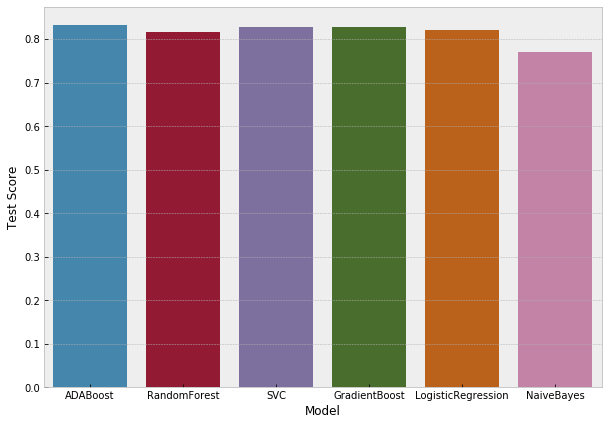

In [417]:
sns.barplot(x = "Model_Name", y = "Test_Score", data = modelResults)
fig = plt.gcf()
fig.set_size_inches(10, 7)
plt.ylabel("Test Score")
plt.xlabel("Model")
plt.show()